In [ ]:
# Importations
!pip install keras-tuner
import keras_tuner as kt
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, LSTM, Reshape, Bidirectional, GRU, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, AdamW

from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.base import BaseEstimator
from sklearn.preprocessing import label_binarize

import seaborn as sns

In [ ]:
class Graphes:

    @staticmethod
    def accuracy_loss_graphe(historique):
        # Affichage accuracy - loss
        fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20, 10))
        axs = axs.flatten()
        axs[0].plot(historique.history["accuracy"], label='Accuracy Train')
        axs[0].plot(historique.history["val_accuracy"], label='Accuracy Val')
        axs[0].set_title(f"Evolution de l'accuracy")
        axs[0].set_xlabel("Epoch")
        axs[0].set_ylabel("Accuracy")
        axs[0].legend()

        axs[1].plot(historique.history["loss"], label='Loss Train')
        axs[1].plot(historique.history["val_loss"], label='Loss Val')
        axs[1].set_title(f"Evolution de la perte")
        axs[1].set_xlabel("Epoch")
        axs[1].set_ylabel("Loss")
        axs[1].legend()
        plt.show()

In [ ]:
class ImageGenerator:

    @staticmethod
    def create_imperfect_image(image, image_size=(56, 56), seed=1):
        random.seed(seed)
        new_image = np.ones((*image_size, image.shape[2]), dtype=np.uint8)

        max_offset = image_size[0] - image.shape[0]
        random_x = random.randint(0, max_offset)
        random_y = random.randint(0, max_offset)

        new_image[random_x:random_x+image.shape[0], random_y:random_y+image.shape[1], :] = image
        return new_image

In [ ]:
def generation_propre(X, y, nb=10000, seed=1):
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.15,
        height_shift_range=0.15,
        zoom_range=0.2,
    )

    new_images_generator = datagen.flow(X, batch_size=1, shuffle=False, seed=seed)

    X_new = X.tolist()
    y_new = y.tolist()
    for i in range(nb):
        img = next(new_images_generator)[0]
        X_new.append(img.tolist())
        y_new.append(y[i].tolist())

        if i < 1:
          plt.figure()
          plt.imshow(img, cmap="grey")
          plt.axis("off")
          plt.show()
    return np.array(X_new), np.array(y_new)


In [34]:
# Création image 56 x 56 avec chiffre positioné aléatoirement
# L'image est ensuite redimensionnée -> 28 x 28

def generation_2(X, y, nb=10000, seed=1):
    new_images = X.tolist()
    new_images_label = y.tolist()

    for i in range(nb):
        imperfect_image = ImageGenerator.create_imperfect_image(X[i], seed=i+seed)

        # imperfect_image = tf.image.resize(imperfect_image, (28, 28))
        imperfect_image = tf.expand_dims(imperfect_image, axis=0)
        imperfect_image = tf.nn.max_pool2d(imperfect_image, ksize=2, strides=2, padding="VALID")

        imperfect_image = imperfect_image.numpy().reshape(28, 28, 1)


        new_images.append(imperfect_image.tolist())
        new_images_label.append(y[i].tolist())

        if i < 1:
          plt.figure()
          plt.imshow(imperfect_image, cmap="grey")
          plt.axis("off")
          plt.show()

    new_images = np.array(new_images)
    new_images_label = np.array(new_images_label)

    return new_images, new_images_label

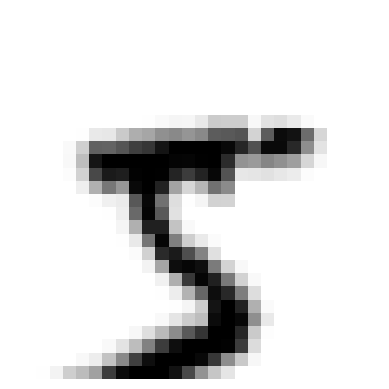

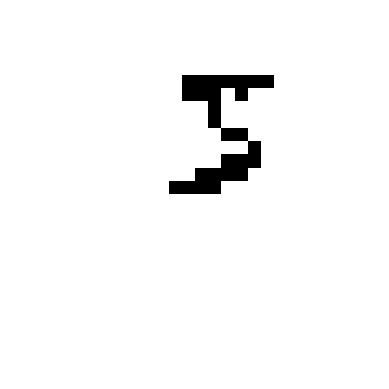

In [ ]:
# Chargement et traitement des données MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# Normalisation
x_train = x_train / 255.0
x_test = x_test / 255.0

# Inversion
x_train = 1 - x_train
x_test = 1 - x_test

# Génération de nouvelles données imparfaites
x_train, y_train = generation_propre(x_train, y_train, 20000)
x_train, y_train = generation_2(x_train, y_train, 25000)

# Mélange (pour validation_split)
np.random.seed(42)
indice = np.random.permutation(len(x_train))
x_train = x_train[indice]
y_train = y_train[indice]

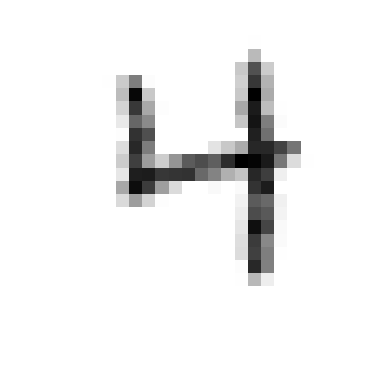

In [ ]:
# Apercu dataset
for i in range(1):
    plt.figure()
    plt.imshow(x_train[i], cmap="grey")
    plt.axis("off")
    plt.show()

In [ ]:
# Optimisation Bayésienne

def build_model(hp):
    model = tf.keras.models.Sequential([
      Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(28, 28, 1)),
      BatchNormalization(),
      MaxPooling2D((2,2), strides=2),
      Dropout(hp.Choice('rate_1', [0.2, 0.3, 0.4])),

      Conv2D(64, (3, 3), activation='relu', padding="same"),
      BatchNormalization(),
      MaxPooling2D((2,2), strides=2),
      Dropout(hp.Choice('rate_2', [0.2, 0.3, 0.4])),

      Reshape((-1, 64)),
      Bidirectional(LSTM(hp.Choice('units', [64, 128, 256, 512]), activation='tanh')),
      BatchNormalization(),
      Dropout(hp.Choice('rate_3', [0.2, 0.3, 0.4, 0.5])),

      Dense(10, activation="softmax")
    ])
    optimizer = Adam(hp.Choice('learning_rate', [0.01, 0.001, 0.0001]), weight_decay=0.0001)
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=['accuracy'])
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
)

tuner.search(x_train, y_train, epochs=5, validation_data=(x_test, y_test))
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Meilleures valeurs trouvées :", best_hyperparameters.values)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
0.3               |0.3               |rate_1
0.3               |0.3               |rate_2
256               |256               |units
0.3               |0.3               |rate_3
0.01              |0.01              |learning_rate

Epoch 1/5


KeyboardInterrupt: 

In [47]:
# Optimisation random search

def build_model(rate_1, rate_2, rate_3, units_1, units_2, activation):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(28, 28, 1)),
        BatchNormalization(),
        MaxPooling2D((2,2), strides=2),
        Dropout(rate_1),

        Conv2D(64, (3, 3), activation='relu', padding="same"),
        BatchNormalization(),
        MaxPooling2D((2,2), strides=2),
        Dropout(rate_1),

        Conv2D(128, (3, 3), activation='relu', padding="same"),
        BatchNormalization(),
        MaxPooling2D((2,2), strides=2),
        Dropout(rate_1),

        Reshape((-1, 128)),

        Bidirectional(GRU(units_1, activation=activation, return_sequences=True)),
        Dropout(rate_2),

        Bidirectional(GRU(units_2, activation=activation)),
        Dropout(rate_3),

        Dense(10, activation="softmax")
    ])

    optimizer = Adam(learning_rate=0.001, weight_decay=0.0001)
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=['accuracy'])

    return model

param_distributions = {
    'rate_1': [0.2, 0.3, 0.4],
    'rate_2': [0.2, 0.3, 0.4, 0.5],
    'rate_3': [0.2, 0.3, 0.4, 0.5],
    'units_1': [64, 128, 256],
    'units_2': [64, 128, 256],
    'activation': ['tanh', 'relu']
}

best_params = {'acc' : 0}
for i in range(20):
  params = []
  for i in range(len(param_distributions)):
    params.append(random.choice(param_distributions[list(param_distributions.keys())[i]]))
  model = build_model(*params)
  historique = model.fit(x_train, y_train, epochs=5, validation_split=0.2, batch_size=64, verbose=0)

  if historique.history['val_accuracy'][-1] > best_params['acc']:
    best_params['acc'] = historique.history['val_accuracy'][-1]
    best_params['params'] = params

print("Meilleurs paramètres trouvés :", best_params)


Meilleurs paramètres trouvés : {'acc': 0.9781904816627502, 'params': [0.2, 0.4, 0.4, 64, 128, 'tanh']}


In [50]:
# Définition du modele

model = tf.keras.models.Sequential([
    Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(28, 28, 1)),
    BatchNormalization(),
    MaxPooling2D((2,2), strides=2),
    Dropout(0.2),

    Conv2D(64, (3, 3), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPooling2D((2,2), strides=2),
    Dropout(0.2),

    Conv2D(128, (3, 3), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPooling2D((2,2), strides=2),
    Dropout(0.2),

    Reshape((-1, 128)),

    Bidirectional(GRU(64, activation='tanh', return_sequences=True)),
    Dropout(0.4),

    Bidirectional(GRU(128, activation='tanh')),
    Dropout(0.4),

    Dense(10, activation="softmax")
])
optimizer = Adam(learning_rate=0.001, weight_decay=0.0001)
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=['accuracy'])



In [51]:
# Entrainement
historique = model.fit(x_train, y_train, epochs=10, validation_split=0.2, batch_size=64)

Epoch 1/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 30s 17ms/step - accuracy: 0.7514 - loss: 0.7416 - val_accuracy: 0.9610 - val_loss: 0.1245
Epoch 2/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.9412 - loss: 0.1836 - val_accuracy: 0.9543 - val_loss: 0.1507
Epoch 3/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.9547 - loss: 0.1455 - val_accuracy: 0.9390 - val_loss: 0.2009
Epoch 4/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.9627 - loss: 0.1208 - val_accuracy: 0.9767 - val_loss: 0.0750
Epoch 5/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.9652 - loss: 0.1090 - val_accuracy: 0.9751 - val_loss: 0.0796
Epoch 6/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.9678 - loss: 0.0999 - val_accuracy: 0.9802 - val_loss: 0.0653
Epoch 7/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.9712 - loss: 0.0947 - val_accuracy: 0.9779 - val_loss: 0.0720
Epoch 8/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.9724 -

In [ ]:
# Sauvegarde

model.save('mon_modele.h5')
from google.colab import files
files.download('mon_modele.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Charger
from tensorflow.keras.models import load_model

model = load_model("model/mon_modele.h5")

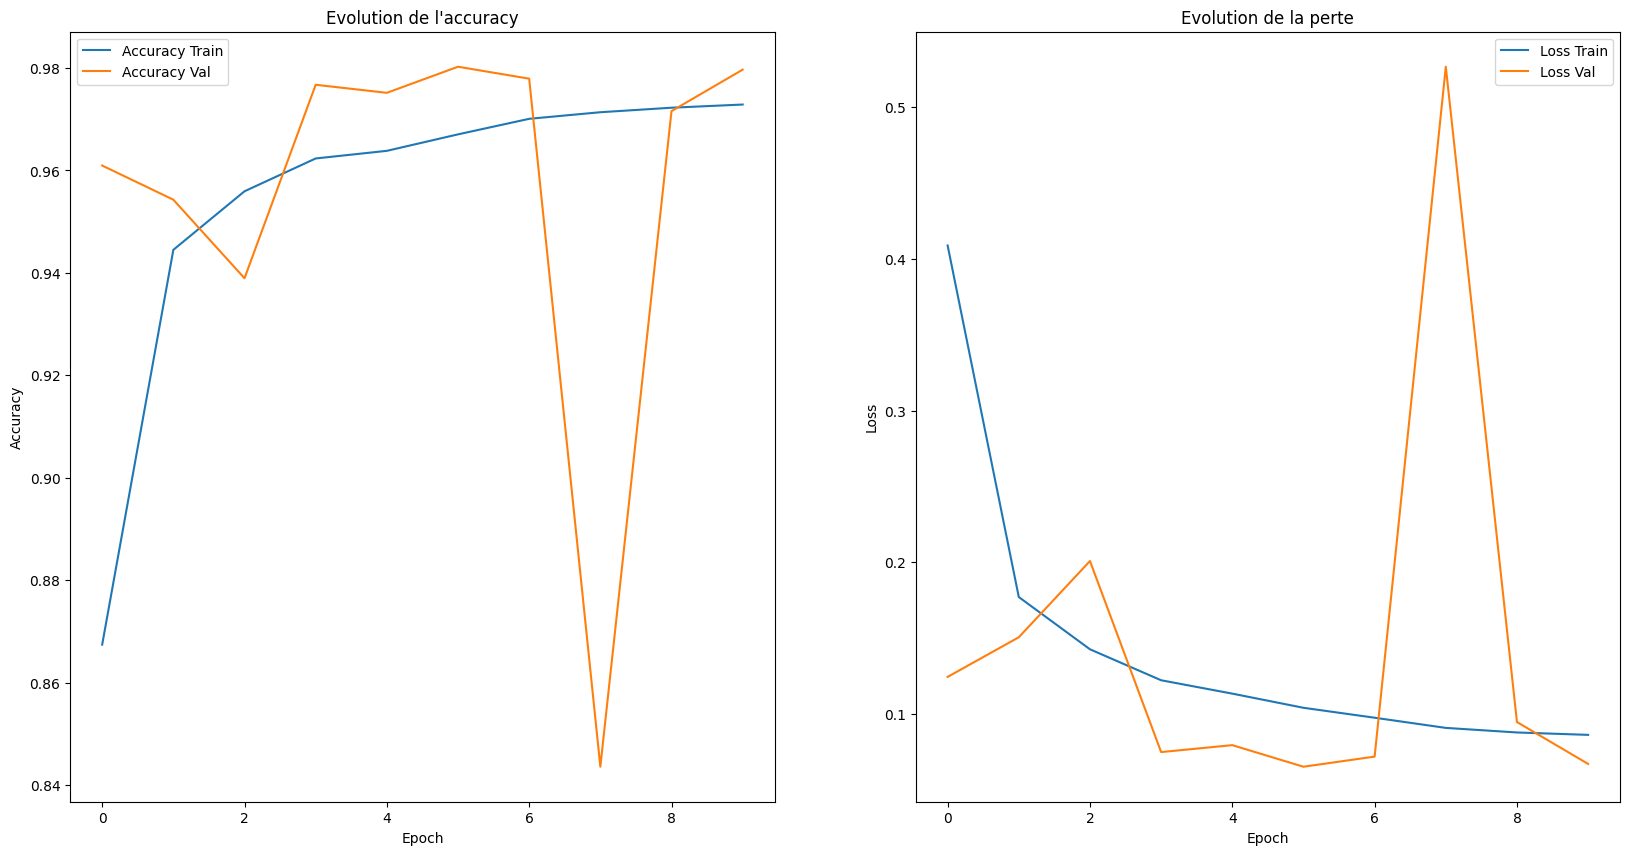

In [52]:
Graphes.accuracy_loss_graphe(historique)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      0.99      1.00      1135
           2       0.99      1.00      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      1.00      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      1.00      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      1.00      0.99       974
           9       1.00      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



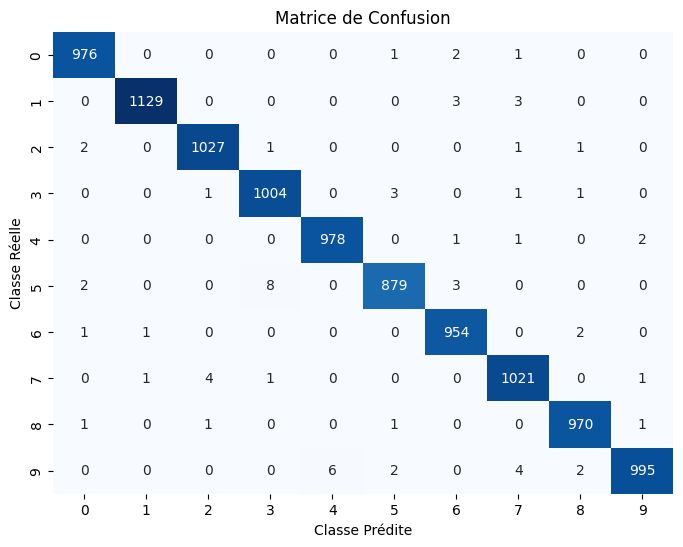

In [53]:
# Stats et matrice de confusion

predictions = np.argmax(model.predict(x_test), axis=1)

print(classification_report(y_test, predictions, target_names=["0","1","2","3","4","5", "6","7", "8", "9"]))

confusion = confusion_matrix(y_test, predictions)

plt.figure(figsize=(8, 6))

sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False)

plt.xlabel("Classe Prédite")
plt.ylabel("Classe Réelle")
plt.title("Matrice de Confusion")
#plt.savefig("img/matrice_conf_1.png", format="png")
plt.show()


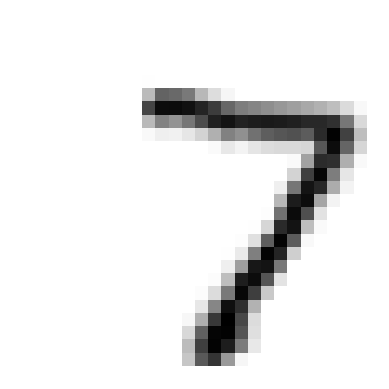

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.98      0.97      1032
           3       0.98      0.98      0.98      1010
           4       0.99      0.97      0.98       982
           5       0.99      0.97      0.98       892
           6       0.96      0.98      0.97       958
           7       0.98      0.98      0.98      1028
           8       1.00      0.97      0.98       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



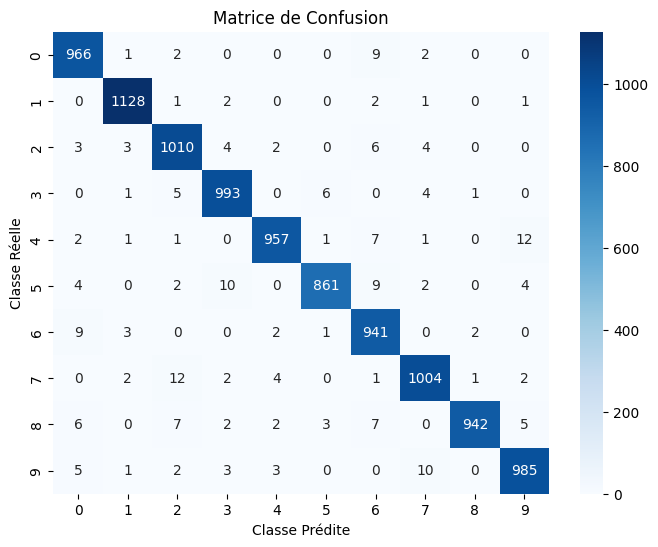

In [54]:
# Stats et matrice de confusion sur données générées (generation_propre)

new_images, new_images_label = generation_propre(x_test, y_test, nb=10000, seed=2)
new_images, new_images_label = new_images[10000:], new_images_label[10000:]


# Résultat sur les nouvelles données

new_pred = np.argmax(model.predict(new_images), axis=1)

print(classification_report(new_images_label, new_pred))

confusion = confusion_matrix(new_images_label, new_pred)

plt.figure(figsize=(8, 6))

sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=True)

plt.xlabel("Classe Prédite")
plt.ylabel("Classe Réelle")
plt.title("Matrice de Confusion")
#plt.savefig("img/matrice_conf_2.png", format="png")
plt.show()



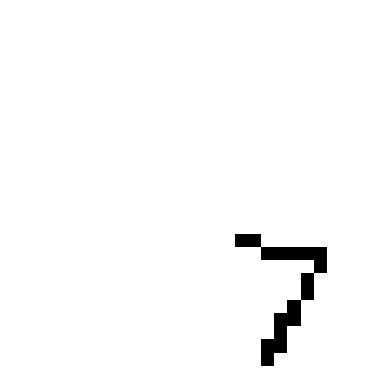

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       980
           1       0.98      0.99      0.99      1135
           2       0.97      0.95      0.96      1032
           3       0.96      0.95      0.95      1010
           4       0.97      0.89      0.93       982
           5       0.96      0.93      0.95       892
           6       0.95      0.96      0.96       958
           7       0.96      0.90      0.93      1028
           8       0.93      0.94      0.93       974
           9       0.84      0.95      0.89      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.94      0.94     10000
weighted avg       0.95      0.95      0.95     10000



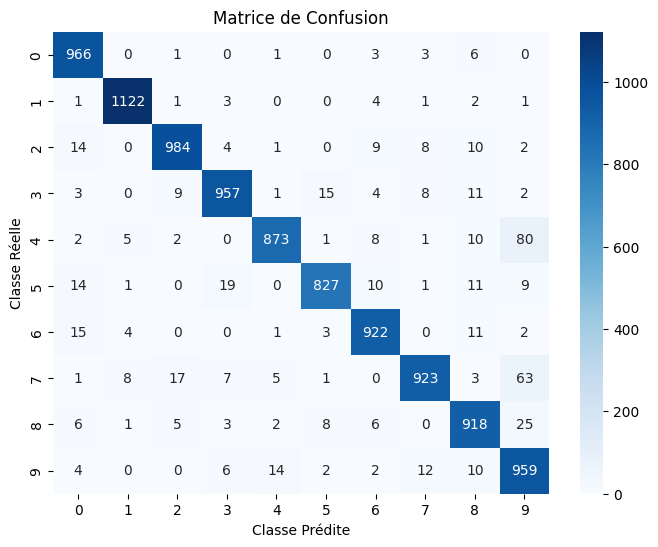

In [55]:
# Stats et matrice de confusion sur données générées (generation_2)

new_images, new_images_label = generation_2(x_test, y_test, seed=2)
new_images, new_images_label = new_images[10000:], new_images_label[10000:]



# Résultat sur les nouvelles données

new_pred = np.argmax(model.predict(new_images), axis=1)

print(classification_report(new_images_label, new_pred))

confusion = confusion_matrix(new_images_label, new_pred)

plt.figure(figsize=(8, 6))

sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=True)

plt.xlabel("Classe Prédite")
plt.ylabel("Classe Réelle")
plt.title("Matrice de Confusion")
#plt.savefig("img/matrice_conf_2.png", format="png")
plt.show()

